## Module Imports

In [1]:
import importMat as im
import experimentList as el
import angleDataframeCreation as adc
import plottingFunctions as pf
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from scipy.signal import spectrogram
from scipy.signal import hilbert, butter, filtfilt, firls, savgol_filter, lfilter, decimate
import scipy.stats as stats
import emd
import constants as const
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import statsmodels.api as sm
from statsmodels.formula.api import ols
import statsmodels

Loading DLC 2.3.6...


## Recreate dataframe (if new data has been added) Do not touch unless regenerating dataframe!

In [2]:
df = adc.createDataFrame()

(2520,)
(2520,)
(2520,)
(2520,)
(2520,)
(2520,)
(2520,)
(2520,)
(2520,)
(2520,)
2025_03_18_E1 added to Dataframe.
(2520,)
(2520,)
(2520,)
(2520,)
(2520,)
(2520,)
(2520,)
(2520,)
(2520,)
(2520,)
2025_03_18_E2 added to Dataframe.
(2520,)
(2520,)
(2520,)
(2520,)
(2520,)
(2520,)
(2520,)
(2520,)
(2520,)
(2520,)
2025_03_18_E3 added to Dataframe.
(2520,)
(2520,)
(2520,)
(2520,)
(2520,)
(2520,)
(2520,)
(2520,)
(2520,)
(2520,)
2025_03_18_E4 added to Dataframe.
(2520,)
(2520,)
(2520,)
(2520,)
(2520,)
(2520,)
(2520,)
(2520,)
(2520,)
(2520,)
2025_03_18_E5 added to Dataframe.
(2520,)
(2520,)
(2520,)
(2520,)
(2520,)
(2520,)
(2520,)
(2520,)
(2520,)
(2520,)
2025_03_19_E1 added to Dataframe.
(2520,)
(2520,)
(2520,)
(2520,)
(2520,)
(2520,)
(2520,)
(2520,)
(2520,)
(2520,)
2025_03_19_E2 added to Dataframe.
(2520,)
(2520,)
(2520,)
(2520,)
(2520,)
(2520,)
(2520,)
(2520,)
(2520,)
(2520,)
2025_03_19_E3 added to Dataframe.
(2520,)
(2520,)
(2520,)
(2520,)
(2520,)
(2520,)
(2520,)
(2520,)
(2520,)
(2520,)
2025_03_

## Load dataframe and create conditional average subDataFrames

In [2]:
df = pf.loadDataFrame(cameraView='dorsal')
# Generates Left Right Conditional Averages : DO NOT DELETE
lra_df = df.reset_index()

for datatype in ['L_wing','R_wing']:
    fnf = ['_Flight_', '_noFlight_']
    flightNames = [stim + fnf[0] + datatype for stim in const.stimNames]
    noflightNames = [stim + fnf[1] + datatype for stim in const.stimNames]
    for idx, name in enumerate(flightNames):
        lra_df[name] = pd.Series(dtype='object')
        lra_df[noflightNames[idx]] = pd.Series(dtype='object')
    for i in lra_df.index:
        traces = lra_df[datatype][i]
        avgs = np.zeros((len(const.stimNames),1))
        stimType = const.stimSeqNames[const.stimSeqNumbers.index(lra_df[const.seq_order_name][i][0])]
        stimSeq = const.stimSeqs[stimType]
        pufferSignal = lra_df[const.puffer_signal_name][i]
        flyingBool = np.zeros(np.shape(avgs))
        flightBool = lra_df['flightBool'][i]
        not_flyingBool = np.zeros(np.shape(avgs))
        for j, stim in enumerate(stimSeq):
            stim_save_idx = const.stimNames.index(stim)
            avgStart = const.stimStart[j] + const.avgStartAndLen[j][0]
            avgEnd = avgStart + const.avgStartAndLen[j][1]
            avgs[stim_save_idx, :] = np.mean(traces[avgStart*const.fps:avgEnd*const.fps], axis=0)
            if np.all(flightBool[avgStart*const.fs:avgEnd*const.fs]):
                flyingBool[stim_save_idx,:] = True
            elif np.all(flightBool[avgStart*const.fs:avgEnd*const.fs] == False):
                not_flyingBool[stim_save_idx,:] = True
            if np.any(pufferSignal[avgStart*const.fs:avgEnd*const.fs] > const.puffer_cutoff_value):
                flyingBool[stim_save_idx,:] = False
                not_flyingBool[stim_save_idx,:] = False
            flyingArray = avgs * flyingBool
            flyingArray[flyingArray == 0] = np.nan
            not_flyingArray = avgs * not_flyingBool
            not_flyingArray[not_flyingArray == 0] = np.nan
        for k in range(len(flyingArray)):
            lra_df[flightNames[k]][i] = flyingArray[k,:]
            lra_df[noflightNames[k]][i] = not_flyingArray[k,:]
            
# Generates Flight Data Conditional Avgs: DO NOT DELETE
fl_df = df.reset_index()

for datatype in ['wbf', 'wba']:
    
    flightNames = [stim + '_Flight_' + datatype for stim in const.stimNames]
    for idx, name in enumerate(flightNames):
        fl_df[name] = pd.Series(dtype='object')
    for i in fl_df.index:
        traces = fl_df[datatype][i]
        avgs = np.zeros((len(const.stimNames),1))
        stimType = const.stimSeqNames[const.stimSeqNumbers.index(fl_df[const.seq_order_name][i][0])]
        stimSeq = const.stimSeqs[stimType]
        pufferSignal = fl_df[const.puffer_signal_name][i]
        flyingBool = np.zeros(np.shape(avgs))
        flightBool = fl_df['flightBool'][i]
        for j, stim in enumerate(stimSeq):
            stim_save_idx = const.stimNames.index(stim)
            avgStart = const.stimStart[j] + const.avgStartAndLen[j][0]
            avgEnd = avgStart + const.avgStartAndLen[j][1]
            avgs[stim_save_idx, :] = np.mean(traces[avgStart*const.fs:avgEnd*const.fs], axis=0)
            if np.all(flightBool[avgStart*const.fs:avgEnd*const.fs]):
                flyingBool[stim_save_idx,:] = True
            if np.any(pufferSignal[avgStart*const.fs:avgEnd*const.fs] > const.puffer_cutoff_value):
                flyingBool[stim_save_idx,:] = False
            flyingArray = avgs * flyingBool
            flyingArray[flyingArray == 0] = np.nan
        for k in range(len(flyingArray)):
            fl_df[flightNames[k]][i] = flyingArray[k,:]
    #flightNames.insert(0,'fly')
    #mindf = fl_df.loc[:,flightNames]
    #min_values = [np.nanmin(np.array([mindf.query('fly==@i').to_numpy() for i in range(el.num_experiments)])[i,:,1:])for i in range(el.num_experiments)]
    #for col_name in flightNames[1:]:
    #    by_fly[(fl_df.query('fly==@i')[col_name]) for i in range(el.num_experiments)]

## Counts in each condition for flight and non-flight

In [3]:
pf.countStats(df)

Condition: wba_test
0_Flight: N= 10 n= 44
50_Flight: N= 10 n= 58
100_Flight: N= 11 n= 62
150_Flight: N= 11 n= 59
200_Flight: N= 11 n= 50
250_Flight: N= 10 n= 38
300_Flight: N= 11 n= 34

Number of flies for condition: 11

Condition: wba_test
0_noFlight: N= 11 n= 51
50_noFlight: N= 11 n= 44
100_noFlight: N= 11 n= 42
150_noFlight: N= 9 n= 43
200_noFlight: N= 11 n= 53
250_noFlight: N= 11 n= 57
300_noFlight: N= 11 n= 60

Number of flies for condition: 11



## Kolmogorov–Smirnov test across conditions to confirm normality

In [4]:
flight_cols = ['0_Flight','50_Flight','100_Flight','150_Flight','200_Flight','250_Flight','300_Flight']
no_flight_cols = ['0_noFlight','50_noFlight','100_noFlight','150_noFlight','200_noFlight','250_noFlight','300_noFlight']
all_cols = [flight_cols, no_flight_cols]
dead_num = 0
for col_list in all_cols:
    for condition in df['condition'].unique():
        print('Condition: ' + condition)
        N_list = []
        n_list = []
        dead_num += 1
        for col in col_list:
            nanBool = ~np.isnan(np.nanmean(pf.extractConditionalAvgs(col,df[df['condition'] == condition]),axis=2))
            N = np.sum(np.count_nonzero(nanBool, axis=1) > 0)
            n = np.sum(np.count_nonzero(nanBool, axis=1))
            print(col + ': ' + 'N= ' + str(N) + ' ' + 'n= ' + str(n))
            N_list.append(N)
            n_list.append(n)
            if dead_num != 2: 
                data = np.nanmean(pf.extractConditionalAvgs(col,df[df['condition'] == condition]),axis=1)
                act_seg = data[~np.isnan(data)]
                active_seg_normality = stats.kstest(act_seg,'norm',args=(np.mean(act_seg),np.std(act_seg,ddof=1)))
                print('wingbeat amplitude normality test:')
                print(active_seg_normality)
                print()
            
                                       
        print()
        print('Number of flies for condition: ' + str(np.max(N_list)))
        print()

Condition: wba_test
0_Flight: N= 10 n= 44
wingbeat amplitude normality test:
KstestResult(statistic=0.17297253468099627, pvalue=0.8779030909730389, statistic_location=77.57425925925925, statistic_sign=1)

50_Flight: N= 10 n= 58
wingbeat amplitude normality test:
KstestResult(statistic=0.15594293030057882, pvalue=0.938159460493514, statistic_location=104.18849206349206, statistic_sign=1)

100_Flight: N= 11 n= 62
wingbeat amplitude normality test:
KstestResult(statistic=0.14411014057845883, pvalue=0.9520627360180337, statistic_location=115.11701388888889, statistic_sign=1)

150_Flight: N= 11 n= 59
wingbeat amplitude normality test:
KstestResult(statistic=0.15304790017723185, pvalue=0.9252772193133936, statistic_location=118.46731481481483, statistic_sign=-1)

200_Flight: N= 11 n= 50
wingbeat amplitude normality test:
KstestResult(statistic=0.15441630120816863, pvalue=0.9205697577684894, statistic_location=131.08342592592592, statistic_sign=-1)

250_Flight: N= 10 n= 38
wingbeat amplitude 

## S1D

LinregressResult(slope=-0.009738423132203775, intercept=4.338516861552946, rvalue=-0.7754342618137386, pvalue=5.032014974616992e-16, stderr=0.000934547657388622, intercept_stderr=0.22512783820589255)


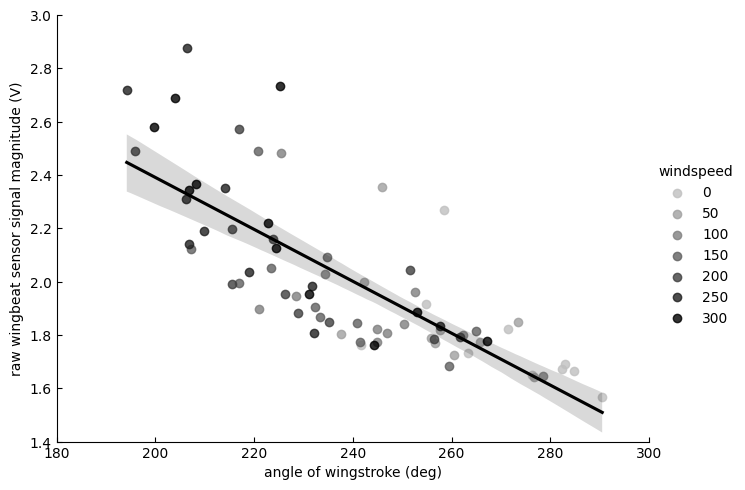

In [7]:
cmap = [np.array([0,0,0])/255,np.array([32,32,32])/255,np.array([64,64,64])/255,np.array([96,96,96])/255,np.array([128,128,128])/255,np.array([160,160,160])/255,np.array([192,192,192])/255]
catg_names = ['0', '50', '100', '150', '200', '250', '300']
col_list_flight = ['0_Flight','50_Flight','100_Flight','150_Flight','200_Flight','250_Flight','300_Flight']
col_list_wba = ['0_Flight_wba','50_Flight_wba','100_Flight_wba','150_Flight_wba','200_Flight_wba','250_Flight_wba','300_Flight_wba']

df_plot_list = []
for i, col in enumerate(col_list_flight):
    df_ws = pd.DataFrame()
    iaa = [np.nanmean(group[col].to_numpy()) for _, group in fl_df.groupby('fly')]
    wba = [np.nanmean(group[col_list_wba[i]].to_numpy()) for _, group in fl_df.groupby('fly')]
    df_ws['fly'] = list(range(fl_df['fly'].max()+1))
    df_ws['windspeed'] = catg_names[i]
    df_ws['wing_ang'] = [360-ang for ang in iaa]
    df_ws['wba'] = wba
    df_plot_list.append(df_ws)
df_plot = pd.concat(df_plot_list)

g = sns.lmplot(x='wing_ang', y='wba', hue='windspeed', data=df_plot, fit_reg=False,palette=cmap[::-1],aspect=1.35)
sns.regplot(x='wing_ang', y='wba', data=df_plot, scatter=False, ax=g.axes[0,0],color='k')
g.axes[0,0].set_xlim([180,300])
g.axes[0,0].set_ylim([1.4,3])
g.axes[0,0].set_ylabel([1.2,3])
g.axes[0,0].set_xlabel('angle of wingstroke (deg)')
g.axes[0,0].set_ylabel('raw wingbeat sensor signal magnitude (V)')
g.axes[0,0].tick_params(direction="in")


wba_vals = df_plot['wba'].to_numpy()
wba_vals = wba_vals[~np.isnan(wba_vals)]
wing_ang_vals = df_plot['wing_ang'].to_numpy()
wing_ang_vals = wing_ang_vals[~np.isnan(wing_ang_vals)]
print(stats.linregress(wing_ang_vals,wba_vals))
g.savefig('S1D.pdf')

## S1B

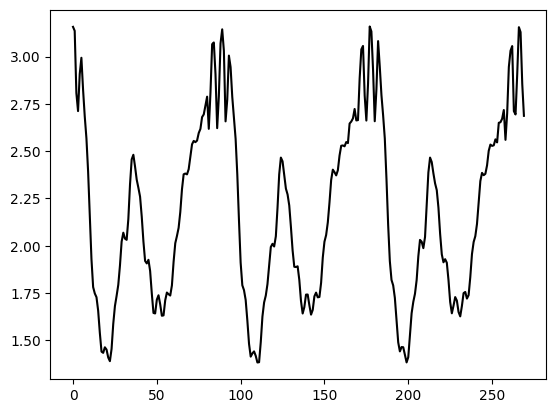

In [6]:
fig,ax=plt.subplots()
tchySig = df.reset_index()['tachometerSignal'][1][199970:200240]

ax.plot(tchySig,c='k')
fig.savefig('S1B.pdf')